In [2]:
output_dir = "/content/drive/MyDrive/models/model 15 | 2024-05-27"

# 1) Install and import libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install evaluate seqeval
!pip install onnx onnxruntime onnxconverter-common
!pip install optimum
!pip install -U datasets
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=346bc2d9201a44c533b8856adba9dafbe1ac75fe58e385c4cd63762b85756432
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [5]:
import os
import json
import numpy as np
import torch
import onnx
import onnxruntime
from pathlib import Path
import matplotlib.pyplot as plt

from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from optimum.exporters.tasks import TasksManager
from optimum.exporters.onnx import export as onnx_export
from onnxruntime.quantization import (
    quantize_dynamic,
    quantize_static,
    QuantFormat,
    QuantType,
    CalibrationDataReader
)
from onnxconverter_common import float16

# 2) Configurations & Setup

In [6]:
model_checkpoint = "google/mobilebert-uncased"             # 95 MB
# model_checkpoint = "distilbert/distilbert-base-uncased"   # 253 MB
# model_checkpoint = 'microsoft/MiniLM-L12-H384-uncased'    # 127 MB
# model_checkpoint = 'prajjwal1/bert-tiny'                  # 17 MB

num_epochs = 20
batch_size = 16
learning_rate = 0.00005

# Define labels
entity_labels = ["HOSP", "PERSON", "STAFF","PHONE", "ID", "EMAIL", "LOC", "ORG", "AGE", "BIRTHDATE", "DATE", "TIMESTAMPS", "URL"]
all_labels = ["O"] + entity_labels
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Labels:", all_labels)

# Disable W&B if don't want to log there - no need for now (optional)
os.environ["WANDB_DISABLED"] = "true"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Labels: ['O', 'HOSP', 'PERSON', 'STAFF', 'PHONE', 'ID', 'EMAIL', 'LOC', 'ORG', 'AGE', 'BIRTHDATE', 'DATE', 'TIMESTAMPS', 'URL']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 3) Load the dataset

In [8]:

data_files = {
    "train": "train.json",
    "validation": "validation.json"
}

raw_dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

# 4) Alignment function to map entity spans to token labels

In [9]:
def align_spans_to_tokens(examples):
    texts = examples["sentence"]
    batch_tokenized = tokenizer(
        texts,
        truncation=True,
        return_offsets_mapping=True
    )

    new_labels = []
    for i, offsets in enumerate(batch_tokenized["offset_mapping"]):
        spans = examples["spans"][i]
        span_entities = [(s["start"], s["end"], s["label"]) for s in spans]

        token_labels = ["O"] * len(offsets)

        for span_start, span_end, span_label in span_entities:
            for idx, (token_start, token_end) in enumerate(offsets):
                # Ignore special token offsets, typically (0, 0)
                if token_start == 0 and token_end == 0:
                    continue
                # If there's overlap, assign label
                if token_end > span_start and token_start < span_end:
                    token_labels[idx] = span_label

        label_ids = [label2id[label] for label in token_labels]
        new_labels.append(label_ids)

    batch_tokenized["labels"] = new_labels
    # We don't need offsets once we've created labels
    batch_tokenized.pop("offset_mapping")
    return batch_tokenized

# 5) Apply the alignment to create encoded dataset

In [10]:
encoded_dataset = raw_dataset.map(
    align_spans_to_tokens,
    batched=True,
    remove_columns=raw_dataset["train"].column_names
)

train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/223 [00:00<?, ? examples/s]

# 6) Load model and move to device (if cuda available)

In [11]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

# Create data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForTokenClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


# 7) Set up evaluation metric (seqeval)

In [12]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for label_ids, pred_ids in zip(labels, predictions):
        # Filter out ignored indices if any (e.g., -100)
        filtered_labels = []
        filtered_preds = []
        for l, p_ in zip(label_ids, pred_ids):
            if l != -100:
                filtered_labels.append(id2label[l])
                filtered_preds.append(id2label[p_])

        true_labels.append(filtered_labels)
        true_predictions.append(filtered_preds)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


# 8) Define training arguments

In [13]:
training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    eval_strategy="epoch",          # <— changed from evaluation_strategy
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=20,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 9) Create Trainer and start training

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
trainer.train()

# Evaluate the final model
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

# Save final model & tokenizer
trainer.save_model("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

<ipython-input-14-49591d0f0d31>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.770900,1.383801,0.014461,0.021904,0.017420,0.659284
2,0.359900,0.289535,0.561990,0.637742,0.597474,0.912993
3,0.103100,0.108884,0.819423,0.909857,0.862275,0.963332
4,0.055300,0.079330,0.902200,0.932603,0.917150,0.976367
5,0.026700,0.067654,0.926809,0.949452,0.937994,0.982302
6,0.026700,0.079990,0.937607,0.924179,0.930844,0.978911
7,0.011300,0.069495,0.946755,0.958719,0.952700,0.983891
8,0.010100,0.070758,0.940150,0.952822,0.946444,0.982726
9,0.006700,0.082566,0.941324,0.946083,0.943697,0.983680
10,0.003500,0.091572,0.950337,0.951137,0.950737,0.983680


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: URL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: EMAIL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ID seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171:

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: URL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: EMAIL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ID seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171:

Evaluation metrics: {'eval_loss': 0.06949494034051895, 'eval_precision': 0.9467554076539102, 'eval_recall': 0.9587194608256108, 'eval_f1': 0.9526998744244454, 'eval_accuracy': 0.9838914794404409, 'eval_runtime': 1.2938, 'eval_samples_per_second': 172.355, 'eval_steps_per_second': 10.821, 'epoch': 10.0}


('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.txt',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

# 10) Save the final model & tokenizer

In [15]:
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/models/model 15 | 2024-05-27/tokenizer_config.json',
 '/content/drive/MyDrive/models/model 15 | 2024-05-27/special_tokens_map.json',
 '/content/drive/MyDrive/models/model 15 | 2024-05-27/vocab.txt',
 '/content/drive/MyDrive/models/model 15 | 2024-05-27/added_tokens.json',
 '/content/drive/MyDrive/models/model 15 | 2024-05-27/tokenizer.json')

# Plot graphs

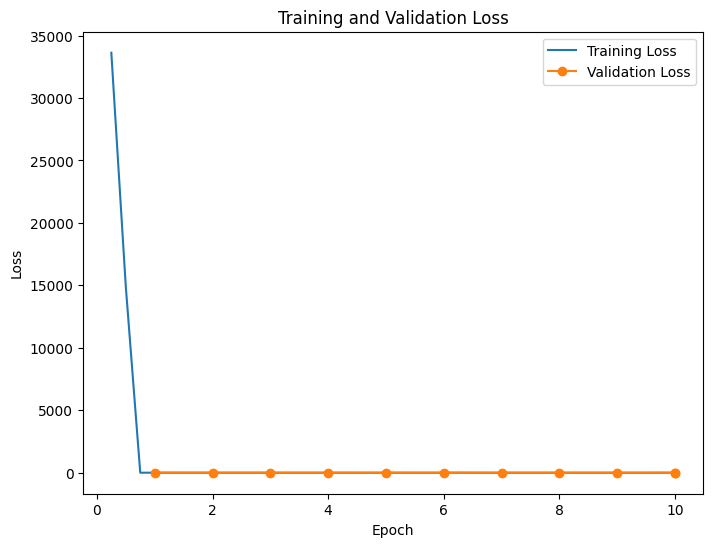

<Figure size 640x480 with 0 Axes>

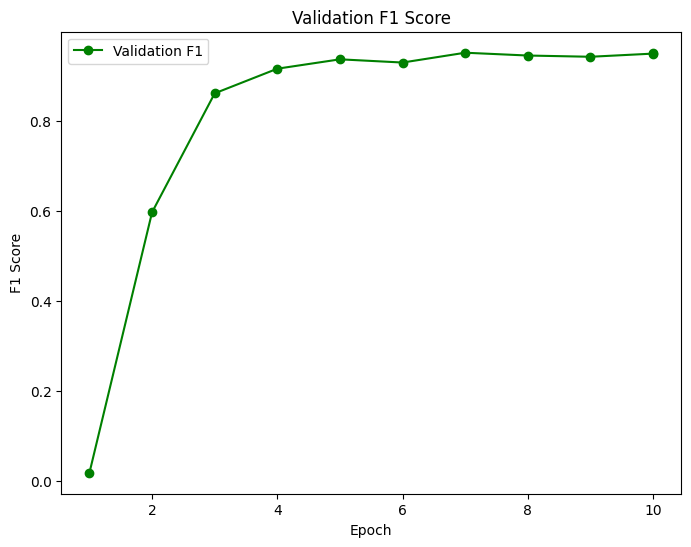

<Figure size 640x480 with 0 Axes>

In [16]:
# Extract the log history
log_history = trainer.state.log_history

# 1) Plot Training vs. Validation Loss
train_loss_vals = []
train_epochs = []
eval_loss_vals = []
eval_epochs = []

for entry in log_history:
    # Training loss entries
    if "loss" in entry and "epoch" in entry:
        train_loss_vals.append(entry["loss"])
        train_epochs.append(entry["epoch"])
    # Evaluation loss entries
    if "eval_loss" in entry and "epoch" in entry:
        eval_loss_vals.append(entry["eval_loss"])
        eval_epochs.append(entry["epoch"])

plt.figure(figsize=(8, 6))
plt.plot(train_epochs, train_loss_vals, label="Training Loss")
plt.plot(eval_epochs, eval_loss_vals, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
plt.savefig( output_dir + "/Training and Validation Loss.png")

# 2) Plot F1 Score over time
eval_f1_vals = []
eval_f1_epochs = []

for entry in log_history:
    if "eval_f1" in entry and "epoch" in entry:
        eval_f1_vals.append(entry["eval_f1"])
        eval_f1_epochs.append(entry["epoch"])

plt.figure(figsize=(8, 6))
plt.plot(eval_f1_epochs, eval_f1_vals, label="Validation F1", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.show()
plt.savefig( output_dir + "/eval_f1_vals.png")


# 11) Inference / Testing the Trained Model (Optional)

In [17]:
# Example input text
test_text = """Immunization Report
Patient Name: Sandamali Herath
Patient ID: 6269540V
Date of Birth: March 15, 2010
Report ID: IMMU7890
Physician Name: Dr.Hemal Senanayake
Date of Report: April 10, 2024

Immunization Record
Vaccine Name	Date Administered	Dose	Site of Administration	Administered By
Hepatitis B	January 20, 2021	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
Influenza (Flu)	October 5, 2023	0.5 mL	Right Arm	Nurse Nuthara Pathirana
Measles-Mumps-Rubella	April 15, 2021	0.5 mL	Left Thigh	Dr.Hemal Senanayake
Tetanus (Tdap)	June 10, 2022	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
COVID-19 (Pfizer)	May 12, 2023	0.3 mL	Right Deltoid	Nurse Nuthara Pathirana
Notes
Upcoming Vaccines: HPV vaccine scheduled for June 2024.
Adverse Reactions: None reported for any administered vaccines.
Clinic Information:
Kalubowila Main Hospital
No 1, Kalubowila Hospital, Kalubowila, Colombo
Contact: (+94)6281110123
"""

In [18]:
# Load the trained model and tokenizer
model_path = "fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

id2label = model.config.id2label  # Should already be stored in config

# Tokenize
inputs = tokenizer(test_text, return_tensors="pt", truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=2).cpu().numpy()[0]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0])

# Print token and predicted label
for token, pred_id in zip(tokens, predictions):
    label = id2label[pred_id]
    # Skip special tokens
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t{label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


im	O
##mun	O
##ization	O
report	O
patient	O
name	O
:	O
sand	PERSON
##ama	PERSON
##li	PERSON
her	PERSON
##ath	PERSON
patient	O
id	O
:	O
62	ID
##6	ID
##9	ID
##54	ID
##0	ID
##v	ID
date	O
of	O
birth	O
:	O
march	BIRTHDATE
15	BIRTHDATE
,	BIRTHDATE
2010	BIRTHDATE
report	O
id	O
:	O
im	ID
##mu	ID
##7	ID
##8	ID
##90	ID
physician	O
name	O
:	O
dr	STAFF
.	STAFF
hem	STAFF
##al	STAFF
sen	STAFF
##ana	STAFF
##ya	STAFF
##ke	STAFF
date	O
of	O
report	O
:	O
april	DATE
10	DATE
,	DATE
202	DATE
##4	DATE
im	O
##mun	O
##ization	O
record	O
vaccine	O
name	O
date	O
administered	O
dose	O
site	O
of	O
administration	O
administered	O
by	O
hepatitis	O
b	O
january	DATE
20	DATE
,	DATE
2021	DATE
0	O
.	O
5	O
ml	O
left	O
del	O
##to	O
##id	O
nurse	O
kamal	STAFF
##a	STAFF
se	STAFF
##lva	STAFF
##raj	STAFF
influenza	O
(	O
flu	O
)	O
october	DATE
5	DATE
,	DATE
202	DATE
##3	DATE
0	O
.	O
5	O
ml	O
right	O
arm	O
nurse	STAFF
nut	STAFF
##hara	STAFF
path	STAFF
##ira	STAFF
##na	STAFF
me	O
##as	O
##les	O
-	O
mum	O
##ps	O
-	O
rub	O
##ella	

# Convrt to ONNX and Save ONNX model

In [19]:
onnx_config_constructor = TasksManager.get_exporter_config_constructor(
    model=model,                # Trained model
    task="token-classification", # The task name
    exporter="onnx"             # Exporter type
)

onnx_config = onnx_config_constructor(model.config)

# (Optional) Adjust opset or other config settings if needed
# onnx_config.dynamic_axes = {
#     "input_ids": {0: "batch_size", 1: "sequence_length"},
#     "attention_mask": {0: "batch_size", 1: "sequence_length"}
# }

# Export the model
onnx_path = Path(output_dir+"/model.onnx")
model.cpu()
onnx_export(
    model=model,
    config=onnx_config,
    opset=12,         # or whichever opset version you want
    output=onnx_path, # Save to this file
    device="cpu"      # Typically "cpu" for export, but can be "cuda" if you prefer
)

print(f"ONNX model has been saved to {onnx_path}")


Passing the argument `library_name` to `get_supported_tasks_for_model_type` is required, but got library_name=None. Defaulting to `transformers`. An error will be raised in a future version of Optimum if `library_name` is not provided.
/usr/local/lib/python3.11/dist-packages/transformers/models/mobilebert/modeling_mobilebert.py:547: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(1000),
/usr/local/lib/python3.11/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(

ONNX model has been saved to /content/drive/MyDrive/models/model 15 | 2024-05-27/model.onnx


# Test onnx model (Optional)

In [20]:
onnx_model_path = output_dir+"/model.onnx"

# Load the tokenizer from saved "fine_tuned_model" directory
# tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    # already loaded before

# Create an ONNX Runtime session
ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Tokenize the text
encoded_inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True
)

# Convert to numpy for ONNX
# (input_ids, attention_mask, and token_type_ids if they exist)
inputs_onnx = {k: v.cpu().numpy() for k, v in encoded_inputs.items()}

# Run inference
outputs = ort_session.run(None, inputs_onnx)
# ONNX export for TokenClassification will produce a single output:
# logits of shape (batch_size, sequence_length, num_labels)
logits = outputs[0]

# Take the argmax to get predicted label IDs
predictions_onnx = np.argmax(logits, axis=2)[0]  # shape: (sequence_length,)

# Convert IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_inputs["input_ids"][0])


def printresults():
    print(f"Token\t|\tlabel_py_t\t|\tlabel_onnx")
    print("-"*50)
    for token, pred_id, pred_id_onnx in zip(tokens, predictions, predictions_onnx):
        label = id2label[pred_id]
        label_onnx = id2label[pred_id_onnx]
        if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            if label != label_onnx:
                print(f"{token}\t\t\t{label}\t\t\t{label_onnx}\t\t\t---DIFFERENT")
            else:
                print(f"{token}\t\t\t{label}\t\t\t{label_onnx}")

printresults()


Token	|	label_py_t	|	label_onnx
--------------------------------------------------
im			O			O
##mun			O			O
##ization			O			O
report			O			O
patient			O			O
name			O			O
:			O			O
sand			PERSON			PERSON
##ama			PERSON			PERSON
##li			PERSON			PERSON
her			PERSON			PERSON
##ath			PERSON			PERSON
patient			O			O
id			O			O
:			O			O
62			ID			ID
##6			ID			ID
##9			ID			ID
##54			ID			ID
##0			ID			ID
##v			ID			ID
date			O			O
of			O			O
birth			O			O
:			O			O
march			BIRTHDATE			BIRTHDATE
15			BIRTHDATE			BIRTHDATE
,			BIRTHDATE			BIRTHDATE
2010			BIRTHDATE			BIRTHDATE
report			O			O
id			O			O
:			O			O
im			ID			ID
##mu			ID			ID
##7			ID			ID
##8			ID			ID
##90			ID			ID
physician			O			O
name			O			O
:			O			O
dr			STAFF			STAFF
.			STAFF			STAFF
hem			STAFF			STAFF
##al			STAFF			STAFF
sen			STAFF			STAFF
##ana			STAFF			STAFF
##ya			STAFF			STAFF
##ke			STAFF			STAFF
date			O			O
of			O			O
report			O			O
:			O			O
april			DATE			DATE
10			DATE			DATE
,			DATE			DATE
202			DATE	

# fp16 Model Quantization

In [21]:
# Paths
model_path = f"{output_dir}/model.onnx"
quantized_model_path = f"{output_dir}/model_fp16.onnx"

# quantize_dynamic(
#     model_input=model_path,
#     model_output=quantized_model_path,
#     weight_type=QuantType.QUInt8
# )

model = onnx.load(model_path)
model_fp16 = float16.convert_float_to_float16(model, keep_io_types=True)
onnx.save(model_fp16, quantized_model_path)

print("Quantized model saved to:", quantized_model_path)

/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 1.3769115625450468e-08 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -4.8995154600106616e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -4.843591305814243e-09 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 7.073449381778119e-08 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".for

Quantized model saved to: /content/drive/MyDrive/models/model 15 | 2024-05-27/model_fp16.onnx


## Test models - Pytourch model | ONNX Model | quantized ONNX model (Optional)

In [22]:
# Path to quantized ONNX model
quantized_model_path = output_dir+"/model_fp16.onnx"

# Load the tokenizer from saved "fine_tuned_model" directory
# tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    # already loaded before

# Create an ONNX Runtime session
ort_session_for_fp16 = onnxruntime.InferenceSession(quantized_model_path)

# Run inference
outputs_fp16 = ort_session_for_fp16.run(None, inputs_onnx)
# ONNX export for TokenClassification will produce a single output:
# logits of shape (batch_size, sequence_length, num_labels)
logits = outputs_fp16[0]

# Take the argmax to get predicted label IDs
predictions_quantized_onnx = np.argmax(logits, axis=2)[0]  # shape: (sequence_length,)

print(f"Token\t|\tpytourch_model\t|\tlabel_onnx|\tquantized_label_onnx")
print("-"*100)
different_count = 0
for token, pred_id_py_t, pred_id_onnx, pred_id_q_onnx in zip(tokens, predictions, predictions_onnx, predictions_quantized_onnx):
    label_py_t = id2label[pred_id_py_t]
    label_onnx = id2label[pred_id_onnx]
    label_q_onnx = id2label[pred_id_q_onnx]

    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        if label_py_t != label_onnx or  label_py_t != label_q_onnx:
            print(f"{token}\t\t\t{label_py_t}\t\t\t{label_onnx}\t\t\t{label_q_onnx}\t\t\t---DIFFERENT")
            different_count+=1
        else:
            print(f"{token}\t\t\t{label_py_t}\t\t\t{label_onnx}\t\t\t{label_q_onnx}")

if different_count:
    print("\n\nDifferences :", different_count)
else:
    print("\n\nNo difference in models")

Token	|	pytourch_model	|	label_onnx|	quantized_label_onnx
----------------------------------------------------------------------------------------------------
im			O			O			O
##mun			O			O			O
##ization			O			O			O
report			O			O			O
patient			O			O			O
name			O			O			O
:			O			O			O
sand			PERSON			PERSON			PERSON
##ama			PERSON			PERSON			PERSON
##li			PERSON			PERSON			PERSON
her			PERSON			PERSON			PERSON
##ath			PERSON			PERSON			PERSON
patient			O			O			O
id			O			O			O
:			O			O			O
62			ID			ID			ID
##6			ID			ID			ID
##9			ID			ID			ID
##54			ID			ID			ID
##0			ID			ID			ID
##v			ID			ID			ID
date			O			O			O
of			O			O			O
birth			O			O			O
:			O			O			O
march			BIRTHDATE			BIRTHDATE			BIRTHDATE
15			BIRTHDATE			BIRTHDATE			BIRTHDATE
,			BIRTHDATE			BIRTHDATE			BIRTHDATE
2010			BIRTHDATE			BIRTHDATE			BIRTHDATE
report			O			O			O
id			O			O			O
:			O			O			O
im			ID			ID			ID
##mu			ID			ID			ID
##7			ID			ID			ID
##8			ID			ID			ID
##90			ID			ID			ID
physician			O			O			O
na

## Run Validation Dataset To Identify Wrong Predictions (Optional)

In [23]:
# Load ONNX model
# onnx_model_path = output_dir+"/model.onnx"
onnx_model_path = output_dir+"/model_fp16.onnx"

ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model", use_fast=True)    #Already did

# Load dataset
datasetName = "validation.json"
with open(datasetName, "r", encoding="utf-8") as f:
    validation_data = json.load(f)

def get_ground_truth_labels(text, spans):
    """Generate ground truth labels for tokenized text."""
    labels = ["O"] * len(text)
    for span in spans:
        start, end, label = span["start"], span["end"], span["label"]
        labels[start:end] = [label] * (end - start)
    return labels

# Process each validation example
count = 0
for example in validation_data:
    text = example["sentence"]
    spans = example["spans"]

    # Tokenize with truncation and padding
    encoded_inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding="max_length", max_length=512, return_offsets_mapping=True
    )

    input_ids = encoded_inputs["input_ids"][0]
    offsets = encoded_inputs["offset_mapping"][0]

    # ONNX requires numpy input
    inputs_onnx = {
        "input_ids": encoded_inputs["input_ids"].cpu().numpy(),
        "attention_mask": encoded_inputs["attention_mask"].cpu().numpy(),
    }

    # Handle models that use token_type_ids
    if "token_type_ids" in encoded_inputs:
        inputs_onnx["token_type_ids"] = encoded_inputs["token_type_ids"].cpu().numpy()

    # Run inference
    outputs = ort_session.run(None, inputs_onnx)
    logits = outputs[0]
    predictions_onnx = np.argmax(logits, axis=2)[0]

    # Convert predictions to labels
    predicted_labels = [id2label.get(pred_id, "O") for pred_id in predictions_onnx]

    # Get ground truth labels
    ground_truth_labels = get_ground_truth_labels(text, spans)

    # Align tokenized words with original text
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    word_labels = []
    word_predictions = []
    word_offsets = []

    for i, (token, offset) in enumerate(zip(tokens, offsets)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue  # Skip special tokens

        start, end = offset.tolist()
        true_label = ground_truth_labels[start] if start < len(ground_truth_labels) else "O"
        pred_label = predicted_labels[i]

        if true_label != pred_label:
            word_labels.append(true_label)
            word_predictions.append(pred_label)
            word_offsets.append(text[start:end])

    # Print misclassified tokens
    if word_labels:
        print("\n--- TEXT ---")
        print(text)
        print("\nWrong Predictions:")
        for word, pred, correct in zip(word_offsets, word_predictions, word_labels):
            print(f"Word: {word}\tPrediction: {pred}\tCorrect: {correct}")
            count+=1
print("Wrong predictions count=",count)



--- TEXT ---
Nurse: Hello, Nilmini Perera. Please confirm your ID 445896325v and phone number 0112569365 before the appointment at Asiri Health PVT Ltd on June 20th.

Wrong Predictions:
Word: PV	Prediction: ORG	Correct: HOSP
Word: T	Prediction: ORG	Correct: HOSP
Word: Ltd	Prediction: ORG	Correct: HOSP

--- TEXT ---
The hiking expedition organized by Harsha Cooray will explore Horton Plains on July 2, 2024.

Wrong Predictions:
Word: ora	Prediction: STAFF	Correct: PERSON
Word: y	Prediction: STAFF	Correct: PERSON

--- TEXT ---
Niall FitzGerald (Gaelic footballer)

Niall FitzGerald (1931 - 2012) was an Irish Gaelic footballer who played as a centre-forward for the CorkMaster team. FitzGerald joined the team during the 1950 championship and was a regular member of the starting fifteen until his retirement following the completion of the 1966 championship. During that time he won one National Football League medal and three Munster medals. FitzGerald was an All-Ireland runner-up on two occa

## Confution matrix

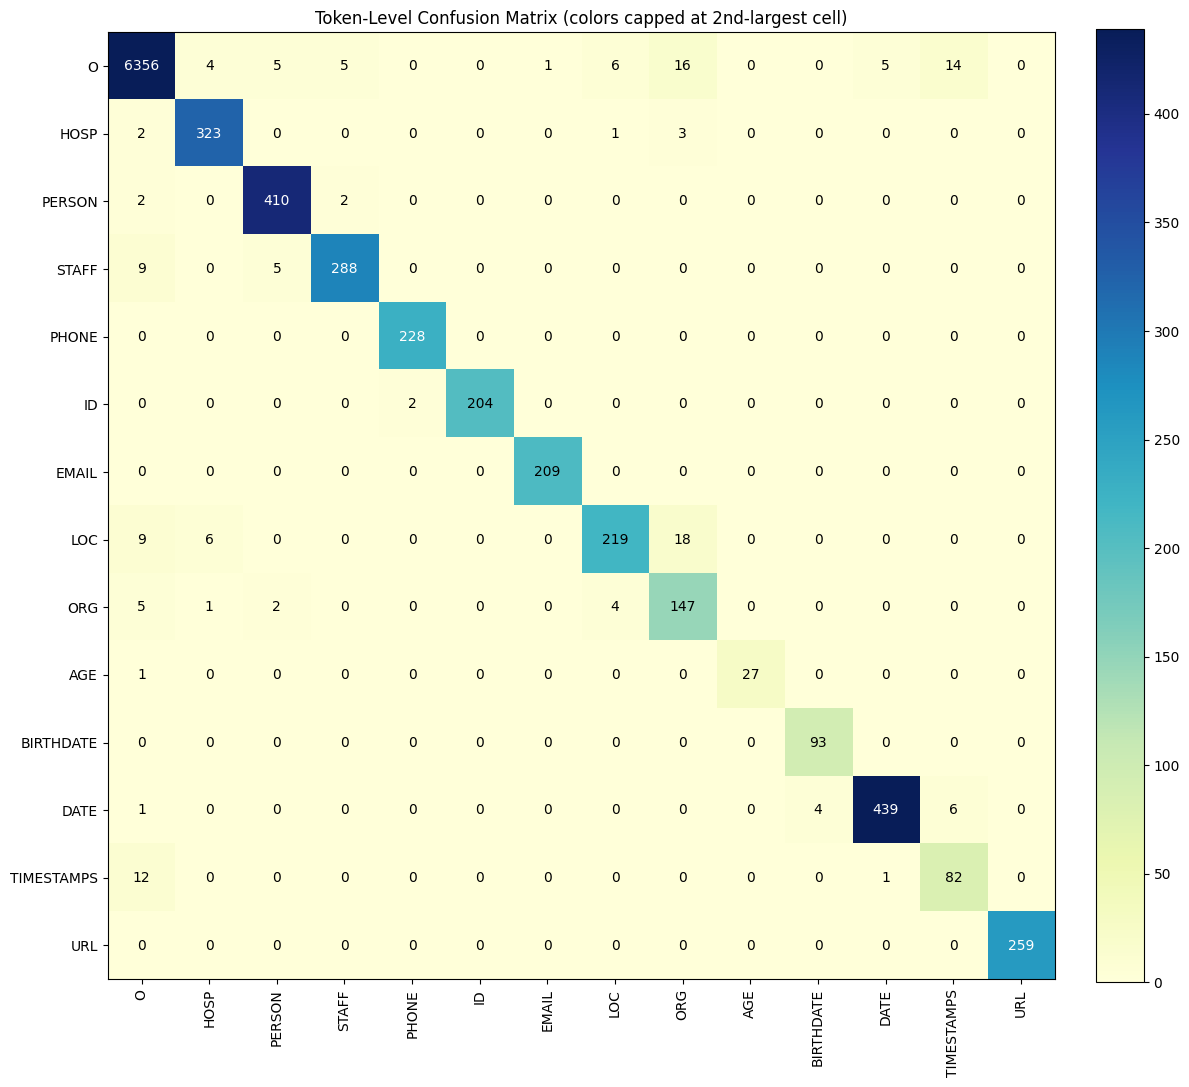

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(
    cm,
    interpolation='nearest',
    norm=norm,
    cmap='YlGnBu'
)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(label_list)))
ax.set_xticklabels(label_list, rotation=90)
ax.set_yticks(np.arange(len(label_list)))
ax.set_yticklabels(label_list)

ax.set_title("Token‐Level Confusion Matrix (colors capped at 2nd‐largest cell)")

# annotate
thresh = vmax / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > thresh else 'black'
        ax.text(j, i, f"{cm[i, j]:d}", ha='center', va='center', color=color)

plt.tight_layout()
plt.show()
fig.savefig(output_dir + "/confusion_matrix.png")
